In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import numpy as np
import pandas as pd
import os, sys
import warnings
warnings.filterwarnings("ignore")
from geopy.distance import geodesic
from tqdm import tqdm
# switch folder
root_dir = "/Users/jiangxuan/Desktop/link_final/beam/test/input/sfbay"
os.chdir(root_dir)
os.getcwd()

'/Users/jiangxuan/Desktop/link_final/beam/test/input/sfbay'

# Reconstruction of Logit Model with activitysim data

$\rightarrow$ (1) calaulate distance
$\rightarrow$ (2) map modes
$\rightarrow$ (3) fit multinomial logit by (Maximum likelihood loss)


Given $y \in \mathbb{R}$, 
$V=\alpha + \beta^{\top} t$


$\alpha \in \mathbb{R}^{m}$

$\beta^{\top} \in \mathbb{R}^{m * k}$


$t \in \mathbb{R}^{k x 1}$


$v \in \mathbb{R}^{m} \rightarrow$ utility of m modes

In [2]:
data_dir = os.path.join(root_dir, "gemini/activitysim-plans-base-2010")
# households
hh = pd.read_csv(os.path.join(data_dir, "households.csv.gz"))
display('Households: ',hh.columns.to_numpy(), hh.head(5))
# parcels (land-use types, useless)
#par = pd.read_csv(os.path.join(data_dir, "parcels.csv.gz"))
#display('Parcel: ', par.columns.to_numpy(), par.head(5))
# persons
per = pd.read_csv(os.path.join(data_dir, "persons.csv.gz"))
display('Persons: ',per.columns.to_numpy(), per.head(5))
# plans
plns = pd.read_csv(os.path.join(data_dir, "plans.csv.gz")).sort_values(by='person_id')
display('Plans: ', plns.columns.to_numpy(), plns.head(5))
# units (useless for modeling)
# unts = pd.read_csv(os.path.join(data_dir, "units.csv.gz"))
# display('Units: ', unts.columns, unts.head(5))

'Households: '

array(['household_id', 'serialno', 'persons', 'cars', 'income',
       'race_of_head', 'age_of_head', 'workers', 'children', 'tenure',
       'recent_mover', 'block_id'], dtype=object)

,household_id,serialno,persons,cars,income,race_of_head,age_of_head,workers,children,tenure,recent_mover,block_id
0,1,2.011001e+12,1,1,131000,1,64,0,0,1,0,60014001001054
1,97,2.010000e+12,2,2,125000,1,50,2,0,1,0,60014001001049
2,193,2.012001e+12,3,2,150800,1,34,1,1,1,0,60014001001026
3,289,2.009001e+12,4,4,300800,1,42,2,2,1,0,60014001001032
4,385,2.009001e+12,2,3,193000,1,47,2,0,1,0,60014001001024


'Persons: '

array(['person_id', 'age', 'earning', 'edu', 'hours', 'household_id',
       'member_id', 'race_id', 'relate', 'sex', 'student', 'work_at_home',
       'worker'], dtype=object)

,person_id,age,earning,edu,hours,household_id,member_id,race_id,relate,sex,student,work_at_home,worker
0,0,64,0,23,0,1,1,1,0,2,0,0,0
1,190,50,25000,22,30,97,1,1,0,2,0,0,1
2,191,50,100000,22,40,97,2,1,13,1,0,0,1
3,379,1,0,0,0,193,3,1,2,2,0,0,0
4,380,34,800,22,10,193,1,1,0,1,0,0,0


'Plans: '

array(['Unnamed: 0', 'trip_id', 'person_id', 'number_of_participants',
       'trip_mode', 'PlanElementIndex', 'ActivityElement', 'ActivityType',
       'x', 'y', 'departure_time'], dtype=object)

,Unnamed: 0,trip_id,person_id,number_of_participants,trip_mode,PlanElementIndex,ActivityElement,ActivityType,x,y,departure_time
0,0,NaN,0.0,NaN,NaN,1,activity,Home,-122.226436,37.855050,11.718
1,1,73.0,0.0,1.0,SHARED2FREE,2,leg,NaN,NaN,NaN,NaN
2,1,NaN,0.0,NaN,NaN,3,activity,escort,-122.076462,37.691972,12.382
3,2,77.0,0.0,1.0,SHARED2PAY,4,leg,NaN,NaN,NaN,NaN
4,2,NaN,0.0,NaN,NaN,5,activity,Home,-122.226436,37.855050,NaN


## Preprocessing Plans data

In [3]:
# Calculate distance
dist = []
ref_id = 0
for i in tqdm(range(len(plns)-1)):
    if plns.person_id[i]==ref_id and plns.person_id[i+1]==ref_id:
        if plns.ActivityElement[i]=='leg':
            x_1, y_1 = plns.x[i-1], plns.y[i-1]
            x_2, y_2 = plns.x[i+1], plns.y[i+1]
            dist.append(geodesic((y_1, x_1), (y_2,x_2)).mi)
        else:
            dist.append(np.nan)
    else:
        ref_id = plns.person_id[i]
        dist.append(np.nan)
dist.append(np.nan)
plns['distance']=dist
display(plns.distance.unique())

100%|██████████| 53229585/53229585 [1:49:56<00:00, 8069.93it/s]


array([        nan, 13.92491625, 12.16967118, ..., 47.2851485 ,
       13.96983528, 52.12649441])

In [4]:
# encode mode
plns_proc = plns.dropna(subset=['trip_mode'])
mode_map = {
        "BIKE": 0,
        "DRIVEALONEFREE": 1,
        "DRIVEALONEPAY": 1,
        "DRIVE_COM": 2,
        "DRIVE_EXP": 2,
        "DRIVE_HVY": 2,
        "DRIVE_LOC": 2,
        "DRIVE_LRF": 2,
        "SHARED2FREE": 1,
        "SHARED2PAY": 1,
        "SHARED3FREE": 1,
        "SHARED3PAY": 1,
        "TAXI": 3,
        "TNC_SHARED": 3,
        "TNC_SINGLE": 3,
        "WALK": 4,
        "WALK_COM": 5,
        "WALK_EXP": 5,
        "WALK_HVY": 5,
        "WALK_LOC": 5,
        "WALK_LRF": 5,
}
plns_proc.trip_mode = plns_proc.trip_mode.apply(lambda x: mode_map[x])
print("After mapping, only %d of data persisted" % len(plns_proc))
plns_proc.head(5)

After mapping, only 23607278 of data persisted


,Unnamed: 0,trip_id,person_id,number_of_participants,trip_mode,PlanElementIndex,ActivityElement,ActivityType,x,y,departure_time,distance
1,1,73.0,0.0,1.0,1,2,leg,NaN,NaN,NaN,NaN,13.924916
3,2,77.0,0.0,1.0,1,4,leg,NaN,NaN,NaN,NaN,13.924916
18,10,535.0,1.0,1.0,1,14,leg,NaN,NaN,NaN,NaN,12.169671
16,9,534.0,1.0,1.0,1,12,leg,NaN,NaN,NaN,NaN,12.169671
14,8,533.0,1.0,1.0,3,10,leg,NaN,NaN,NaN,NaN,0.553689


## Join datasets

In [5]:
ref_list = plns.person_id.astype(int)
joinable_id = []
# extract joinable ids
for id_ in per.person_id:
    if id_ in ref_list:
        joinable_id.append(id_)
print("Joinable" if len(joinable_id)>0 else "Unjoinable")
print(len(joinable_id))
del joinable_id

Joinable
6741462


In [6]:
pln_attrs = ['person_id', 'trip_mode', 'distance']
drop_cols = [ 'serialno', 
                 'person_id', 'household_id', 'recent_mover', 'block_id',
                    'member_id', 'relate', 'workers', 'children',
                        'race_of_head', 'age_of_head']
per_hh = pd.merge(hh, per, on='household_id')
data = pd.merge(plns_proc[pln_attrs], per_hh, on='person_id')
data = data.drop(drop_cols, axis=1)
data = data.dropna()
print("Extracted %d rows of data" % len(data))
display(data.head(5))
data = data[data['age'] > 16]
data.to_csv(os.path.join(root_dir, "./cleaned_joint_data.csv"), sep=',', encoding='utf-8')

Extracted 12178626 rows of data


,trip_mode,distance,persons,cars,income,tenure,age,earning,edu,hours,race_id,sex,student,work_at_home,worker
0,1,13.924916,1,1,131000,1,64,0,23,0,1,2,0,0,0
1,1,13.924916,1,1,131000,1,64,0,23,0,1,2,0,0,0
2,1,12.169671,1,1,142000,1,61,0,21,0,2,2,0,0,0
3,1,12.169671,1,1,142000,1,61,0,21,0,2,2,0,0,0
4,3,0.553689,1,1,142000,1,61,0,21,0,2,2,0,0,0


## Logit Model

In [7]:
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class SF_Dataset(Dataset):
    def __init__(self, dat_dir: str, use_cols: list, label: str='train', one_hot: bool=True) -> None:
        super(SF_Dataset, self).__init__()
        self.data = pd.read_csv(dat_dir, sep=',', usecols=use_cols, encoding='utf-8')
        self.X = self.data.loc[:, self.data.columns!='trip_mode'].to_numpy()
        self.y = self.data.trip_mode.to_numpy()
        self.in_dim, self.out_dim = self.X.shape[1], 6
        self.len = len(self.y)
        if one_hot:
            self.y = self.one_hot_encode(self.y, 6)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if T.is_tensor(idx):
            idx = idx.tolist()
        
        attributes = self.X[idx, :]
        attributes = T.from_numpy(attributes).float()

        mode = self.y[idx]
        mode = T.from_numpy(np.array(mode)).long()
        return attributes, mode
    
    def one_hot_encode(self, int_mode: np.ndarray, total: int):
        res = []
        for k in int_mode:
            empty_choice = np.zeros(total)
            empty_choice[k] += 1
            res.append(empty_choice)
        return np.array(res)

In [8]:
# neural network
class MultiLogit(nn.Module):
    def __init__(self, in_dim: int, out_dim: int) -> None:
        super(MultiLogit, self).__init__()
        self.lyrs = nn.Linear(in_dim, out_dim)
    
    def forward(self, x: T.Tensor) -> T.Tensor:
        x = x.float()
        out = self.lyrs(x)
        # out = nn.functional.softmax(out)
        return out

100%|██████████| 10/10 [53:47<00:00, 322.79s/it]


{'β': array([[-0.03996069,  0.13440172],
        [-0.01011437,  0.1345165 ],
        [ 0.01816616,  0.13438012],
        [-0.0125518 ,  0.13365084],
        [-0.03691471,  0.1348395 ],
        [ 0.00259948,  0.13485804]], dtype=float32),
 'α': array([-1.9175569 ,  1.4632268 , -1.4973674 , -0.19646   ,  0.08283263,
         0.0237768 ], dtype=float32)}

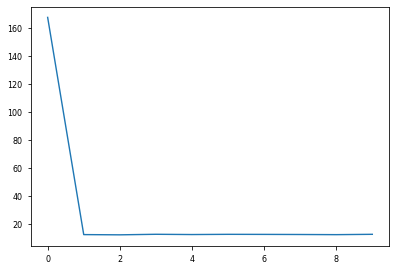

In [12]:
def multi_acc(y_pred: T.Tensor, y_test: T.Tensor) -> float:
    y_pred_softmax = nn.functional.softmax(y_pred, dim = 1)
    _, y_pred_tags = T.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = T.round(acc * 100)
    
    return acc
# training
batch_size, epochs, lr = 1000, 10, 0.001
train_data = SF_Dataset(os.path.join(root_dir, "./cleaned_joint_data.csv"), 
                            use_cols=['earning', 'distance','trip_mode'], one_hot=False)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
model = MultiLogit(train_data.in_dim, train_data.out_dim)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
#lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)
losses = []
for _ in tqdm(range(epochs)):
    epoch_loss = 0
    for step, (x, y_tgt) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y_tgt)
        loss.backward()
        optimizer.step()
        #lr_scheduler.step()
        epoch_loss += loss.detach().data
    losses.append(epoch_loss/(step+1))
plt.plot(np.arange(epochs), losses)
display({name:p  for name, p in zip(
    ['β', 'α'], [param.data.numpy() for param in model.parameters()]
)})